In [2]:
from mhcflurry.dataset import Dataset

Couldn't import dot_parser, loading of dot files will not be possible.


Using Theano backend.


In [52]:
dataset = Dataset.from_csv("../bdata.2009.mhci.public.1.txt")

In [53]:
df = dataset.to_dataframe()

In [54]:
df[df.peptide_length > 12]

species     allele  peptide_length   cv  \
allele    peptide                                                               
H-2-DB    FQPQNGQFIHFYR                 mouse     H-2-DB              13  TBD   
          ILAILAIATLMSV                 mouse     H-2-DB              13  TBD   
          SGVENPGGYCLTK                 mouse     H-2-DB              13  TBD   
          SLAALIVGLVFAL                 mouse     H-2-DB              13  TBD   
          VLGATLLFFVIAL                 mouse     H-2-DB              13  TBD   
          VLGMLIPLSVCSV                 mouse     H-2-DB              13  TBD   
          ILGGGLLVGLLPAV                mouse     H-2-DB              14  TBD   
          ISQAVHAAHAEINE                mouse     H-2-DB              14  TBD   
          TLLVLGILLVVAGL                mouse     H-2-DB              14  TBD   
          AIFQPQNGQFIHFYR               mouse     H-2-DB              15  TBD   
          AIFQPQNGQLIHFYR               mouse     H-2-DB              15  TBD   
          AVYNLATCGIFAISF               mouse     H-2-DB              15  TBD   
          FQPQNGQLIHFYREP               mouse     H-2-DB              15  TBD   
          GIKAVYNLATCGIFA               mouse     H-2-DB              15  TBD   
          LSDSSGAENPGGYCL               mouse     H-2-DB              15  TBD   
          NPGGYCLTKWMILAA               mouse     H-2-DB              15  TBD   
          SGAENPGGYCLTKWM               mouse     H-2-DB              15  TBD   
          VEIAIFQPQNGQLIH               mouse     H-2-DB              15  TBD   
          VITGIKAVYNLATCG               mouse     H-2-DB              15  TBD   
          ISQAVHAAHAEINEAAATYQRTRALV    mouse     H-2-DB              26  TBD   
H-2-KB    FQPQNGQFIHFYR                 mouse     H-2-KB              13  TBD   
          ILAILAIATLMSV                 mouse     H-2-KB              13  TBD   
          SLAALIVGLVFAL                 mouse     H-2-KB              13  TBD   
          VLGATLLFFVIAL                 mouse     H-2-KB              13  TBD   
          VLGMLIPLSVCSV                 mouse     H-2-KB              13  TBD   
          ILGGGLLVGLLPAV                mouse     H-2-KB              14  TBD   
          ISQAVHAAHAEINE                mouse     H-2-KB              14  TBD   
          TLLVLGILLVVAGL                mouse     H-2-KB              14  TBD   
          AIFQPQNGQFIHFYR               mouse     H-2-KB              15  TBD   
          ISQAVHAAHAEINEAAATYQRTRALV    mouse     H-2-KB              26  TBD   
...                                       ...        ...             ...  ...   
HLA-B5401 ERPIFPHPSKPTFLP               human  HLA-B5401              15  TBD   
          IRQAGVQYSRADEEQ               human  HLA-B5401              15  TBD   
          LPGPQVTAVLLHEES               human  HLA-B5401              15  TBD   
          RALIKTLPRASYSSH               human  HLA-B5401              15  TBD   
HLA-B5701 DEPASTEPVHDQLL                human  HLA-B5701              14  TBD   
          FRNLAYGRTCVLGK                human  HLA-B5701              14  TBD   
          LVSDYCNVLNKEFT                human  HLA-B5701              14  TBD   
          NPTQAPVIQLHAVY                human  HLA-B5701              14  TBD   
          QKEEAAICGQMDLS                human  HLA-B5701              14  TBD   
          RKCCRAKFKQLLQH                human  HLA-B5701              14  TBD   
          ERPIFPHPSKPTFLP               human  HLA-B5701              15  TBD   
          LPGPQVTAVLLHEES               human  HLA-B5701              15  TBD   
          RALIKTLPRASYSSH               human  HLA-B5701              15  TBD   
HLA-B5801 DEPASTEPVHDQLL                human  HLA-B5801              14  TBD   
          FRNLAYGRTCVLGK                human  HLA-B5801              14  TBD   
          LVSDYCNVLNKEFT                human  HLA-B5801              14  TBD   
          NPTQAPVIQLHAVY                human  HLA-B5801             

In [169]:

from keras.layers import Input, Embedding, LSTM, Dense, merge, Flatten, Dropout, BatchNormalization, Activation
from keras.models import Model
from keras.layers.advanced_activations import ELU

from sklearn.metrics import roc_auc_score 

from collections import OrderedDict, defaultdict

In [187]:
def add_hidden_layer(x, size, name, dropout, activation, batch_normalization=False):
    x = Dense(size, activation="linear", name=name)(x)
    if batch_normalization:
        x = BatchNormalization()(x)
    if activation == "elu":
        x = ELU()(x)
    else:
        x = Activation(activation)(x)
    if dropout > 0:
        x = Dropout(dropout)(x)
    return x

In [214]:


def make_length_specific_model(
        input_length,
        shared_embedding_layer,
        hidden_activation_function,
        hidden_layer_sizes=[],
        dropout=0.25):
    input_layer = Input(
            shape=(input_length,), 
            dtype="int32", 
            name="input_for_length_%d" % input_length)
    x = Flatten()(shared_embedding_layer(input_layer))
    
    for i, hidden_layer_size in enumerate(hidden_layer_sizes):
        hidden_name = "hidden%d_for_length_%d" % (i + 1, input_length)
        print("Making %s (size=%d)" % (hidden_name, hidden_layer_size))
        x = add_hidden_layer(
                x=x,
                size=hidden_layer_size,
                name=hidden_name, 
                dropout=dropout,
                activation=hidden_activation_function)
    output = Dense(
        output_dim=1, 
        input_dim=hidden_layer_sizes[-1] if hidden_layer_sizes else shared_embedding_layer.output_dim * input_length,
        activation="sigmoid", 
        name="output")(x)
    model = Model(input=[input_layer], output=[output])
    model.compile(optimizer='adam',
              loss={'output': 'mse'},
              loss_weights={'output': 1.})
    return model


In [250]:

def make_length_specific_models(
        lengths, 
        embedding_dim=200,
        hidden_layer_sizes=[],
        embedding_dropout=0.1,
        hidden_dropout=0.25,
        n_amino_acids=20,
        hidden_activation_function="tanh"):
    """
    Make a collection of Keras models which share Embedding and output layers.
    """
    shared_embedding_layer = Embedding(
        input_dim=n_amino_acids,
        output_dim=embedding_dim,
        dropout=embedding_dropout,
        name="amino_acid_embedding")
    
    
    # dictionary mapping each distinct 
    models = {}

    for length in lengths:
        models[length] = make_length_specific_model(
            length,
            shared_embedding_layer=shared_embedding_layer,
            hidden_layer_sizes=hidden_layer_sizes,
            hidden_activation_function=hidden_activation_function,
            dropout=hidden_dropout)
    return models

def train_for_allele(dataset, allele_name="HLA-A0201", lengths=None, n_rounds=25, n_epochs_per_round=1, **kwargs):
    allele_data = dataset.get_allele(allele_name)

    length_datasets = {}
    for length, subset in allele_data.to_dataframe().groupby("peptide_length"):
        print("%d => %d" % (length, len(subset)))
        length_datasets[length] = Dataset(subset)
        
    if not lengths:
        lengths = list(length_datasets.keys())
    print("Lengths: %s" % (lengths,))
    
    models = make_length_specific_models(lengths, **kwargs)
    
    split_datasets = OrderedDict()
    for length, length_dataset in sorted(length_datasets.items(), key=lambda x: len(x[1]), reverse=True):
        if length not in models:
            continue
        """
        kmer_index_encoding returns:
         - 2d array of encoded kmers
         - 1d array of affinity value corresponding to the source
           peptide for each kmer
         - sample_weights (1 / kmer count per peptide)
         - indices of original peptides from which kmers were extracted
        """
        X, ic50, sample_weights, indices = length_dataset.kmer_index_encoding(kmer_size=length, allow_unknown_amino_acids=False)
        assert (sample_weights == 1.0).all(), "Bad sample weights for length %d: %s" % (length, sample_weights)
        n = len(X)
        indices = np.arange(n)
        np.random.shuffle(indices)
        train_indices = indices[:n//2]
        test_indices = indices[n//2:]
        split_datasets[length] = (X[train_indices], X[test_indices], ic50[train_indices], ic50[test_indices])
    
    length_to_aucs = defaultdict(list)

    for i in range(n_rounds):
        for length, (X_train, X_test, ic50_train, ic50_test) in split_datasets.items():
            if length not in models:
                continue
            print("Training model for length=%d with %d samples" % (length, len(ic50_train)))
            # print("Norm of last layer before update: %f" % np.sqrt(np.sum(models[length].get_weights()[-2]**2)))
            y_train = np.maximum(0, 1.0 - (np.log(ic50_train) / np.log(50000.0)))
            models[length].fit(
                X_train,
                y_train,
                verbose=False,
                nb_epoch=n_epochs_per_round,
                batch_size=16)
            # print("Norm of last layer after update: %f" % np.sqrt(np.sum(models[length].get_weights()[-2]**2)))
            label_test = ic50_test <= 500
            if label_test.std() == 0:
                auc = 0.5
            else:
                y_pred = models[length].predict(X_test)
                auc = roc_auc_score(label_test, y_pred)
                print("Round #%d: AUC for length = %d: %f" % (i + 1, length, auc))
            length_to_aucs[length].append(auc)
    return models, length_to_aucs

In [270]:
import seaborn
%matplotlib inline


In [240]:
models, length_to_aucs = train_for_allele(dataset, "HLA-A0201", n_rounds=100, embedding_dim=500, hidden_layer_sizes=[])


8 => 125
9 => 6961
10 => 2356
11 => 92
12 => 8
13 => 6
14 => 10
15 => 7
Training model for length=9 with 3480 samples
Round #1: AUC for length = 9: 0.949958
Training model for length=10 with 1178 samples
Round #1: AUC for length = 10: 0.918536
Training model for length=8 with 62 samples
Round #1: AUC for length = 8: 0.661017
Training model for length=11 with 46 samples
Round #1: AUC for length = 11: 0.697222
Training model for length=14 with 5 samples
Round #1: AUC for length = 14: 0.500000
Training model for length=12 with 4 samples
Training model for length=15 with 3 samples
Round #1: AUC for length = 15: 0.500000
Training model for length=13 with 3 samples
Round #1: AUC for length = 13: 0.500000
Training model for length=9 with 3480 samples
Round #2: AUC for length = 9: 0.957527
Training model for length=10 with 1178 samples
Round #2: AUC for length = 10: 0.924532
Training model for length=8 with 62 samples
Round #2: AUC for length = 8: 0.703390
Training model for length=11 with 46 

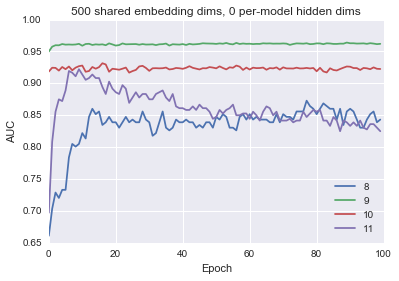

In [242]:
auc_df = pd.DataFrame(length_to_aucs)

legend = []

for i in auc_df.columns:
    if i > 11:
        continue
    seaborn.plt.plot(auc_df.index, auc_df[i])
    legend.append(i)

seaborn.plt.xlabel("Epoch")
seaborn.plt.ylabel("AUC")
seaborn.plt.title("500 shared embedding dims, 0 per-model hidden dims")
seaborn.plt.legend(legend, loc="lower right")

In [283]:
models, length_to_aucs = train_for_allele(
    dataset, 
    "HLA-A0201", 
    n_rounds=100, 
    embedding_dim=50, 
    hidden_layer_sizes=[20])


8 => 125
9 => 6961
10 => 2356
11 => 92
12 => 8
13 => 6
14 => 10
15 => 7
Lengths: [8, 9, 10, 11, 12, 13, 14, 15]
Making hidden1_for_length_8 (size=20)
Making hidden1_for_length_9 (size=20)
Making hidden1_for_length_10 (size=20)
Making hidden1_for_length_11 (size=20)
Making hidden1_for_length_12 (size=20)
Making hidden1_for_length_13 (size=20)
Making hidden1_for_length_14 (size=20)
Making hidden1_for_length_15 (size=20)
Training model for length=9 with 3480 samples
Round #1: AUC for length = 9: 0.943217
Training model for length=10 with 1178 samples
Round #1: AUC for length = 10: 0.891412
Training model for length=8 with 62 samples
Round #1: AUC for length = 8: 0.704678
Training model for length=11 with 46 samples
Round #1: AUC for length = 11: 0.852778
Training model for length=14 with 5 samples
Round #1: AUC for length = 14: 0.500000
Training model for length=12 with 4 samples
Round #1: AUC for length = 12: 0.333333
Training model for length=15 with 3 samples
Training model for length=

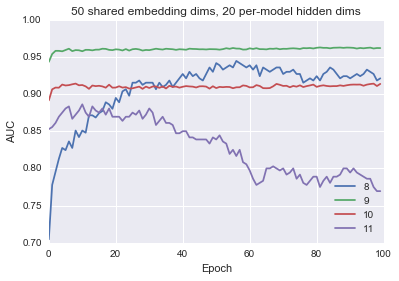

In [284]:
auc_df = pd.DataFrame(length_to_aucs)

legend = []

for i in auc_df.columns:
    if i > 11:
        continue
    seaborn.plt.plot(auc_df.index, auc_df[i])
    legend.append(i)

seaborn.plt.xlabel("Epoch")
seaborn.plt.ylabel("AUC")
seaborn.plt.title("50 shared embedding dims, 20 per-model hidden dims")
seaborn.plt.legend(legend, loc="lower right")

In [289]:
models, length_to_aucs = train_for_allele(
    dataset, "HLA-A0201",
    lengths=[8],
    n_rounds=100,
    embedding_dim=50,
    hidden_layer_sizes=[20])


8 => 125
9 => 6961
10 => 2356
11 => 92
12 => 8
13 => 6
14 => 10
15 => 7
Lengths: [8]
Making hidden1_for_length_8 (size=20)
Training model for length=8 with 62 samples
Round #1: AUC for length = 8: 0.403448
Training model for length=8 with 62 samples
Round #2: AUC for length = 8: 0.358621
Training model for length=8 with 62 samples
Round #3: AUC for length = 8: 0.337931
Training model for length=8 with 62 samples
Round #4: AUC for length = 8: 0.331034
Training model for length=8 with 62 samples
Round #5: AUC for length = 8: 0.320690
Training model for length=8 with 62 samples
Round #6: AUC for length = 8: 0.310345
Training model for length=8 with 62 samples
Round #7: AUC for length = 8: 0.310345
Training model for length=8 with 62 samples
Round #8: AUC for length = 8: 0.303448
Training model for length=8 with 62 samples
Round #9: AUC for length = 8: 0.306897
Training model for length=8 with 62 samples
Round #10: AUC for length = 8: 0.320690
Training model for length=8 with 62 samples
Ro

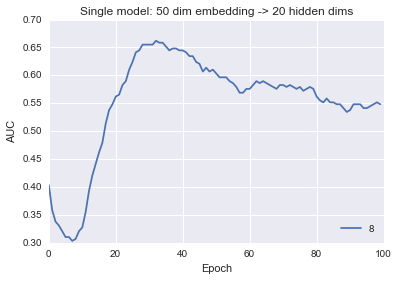

In [290]:
auc_df = pd.DataFrame(length_to_aucs)

legend = []

for i in auc_df.columns:
    if i > 11:
        continue
    seaborn.plt.plot(auc_df.index, auc_df[i])
    legend.append(i)

seaborn.plt.xlabel("Epoch")
seaborn.plt.ylabel("AUC")
seaborn.plt.title("Single model: 50 dim embedding -> 20 hidden dims")
seaborn.plt.legend(legend, loc="lower right")

Is the embedding layer actually shared between different models?

In [273]:
for i in range(len(models[8].get_weights())):
    print(i, np.all((models[8].get_weights()[i] == models[12].get_weights()[i])))

0 True
1 False
2 False
3 False
4 False


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:2: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app
